# Tutorial on Variational Quantum Eigensolver (Part II)
# "*Brute force*" Measurement to Estimate Energy

---
This code was mostly based on Qiskit Variational Quantum Eigensolver Playground, you can find in [Github](https://github.com/JavaFXpert/vqe-playground). It was reduced as much as possible to analyze the core of the VQE Algorithm.  

In the coming paragraphs we are going to analyze all the code step by step. Please run all the cells in order.

We saw that to estimate the energy in **Part I** we accessed the probabilities of each one of the components of the ansatz wavefunction. That is something we definitely cannot peek at in a real quantum computer. The best we can do is a meassurement and there will be probabilities to reach only one of the base states. A quantum computer is inherently probabilistic and we will need to repeat the experiment and measure several times if we want to achieve a certain degree of certainty on the validity of our results.

There are several techniques to minimize the number of experiments or to maximize the probability of getting a correct answer but nothing comes for free. The biggest the certainty the more gates and ancilla(auxiliary) qubits we will need. We are going to explore in this Tutorial simplest of all measurements. We will be directly measuring each of the qubits of the  Ansatz wavefunction.

This step now will be just a measurement and it will be reproducible in a real quantum computer. In the following figure you can see now the new elements of the algorithm differentiated in Blue (Quantum) and Green(Classical).   
<img src="./img/VQE1.2.png" >

# BLA BLA  
# ANTES DE EXPLICAR :: CREAR CODIGO



explica la creacion del hamiltonian
explica los distintos terms del hamiltonian
explica que para sacar el valor esperado es igual que por separado

que lo que haremos es preparar medir los  5 qubits con 1000 experimentos

que hallaremos asi la probabilidad de cada uno de los 32 estados base (2^5 qubits) del la funcion de onda ansatz.

que una vez hallado esto calcularemos el valor esperado de los 6 terms  de forma clasica con Pi i=1..31

y los sumaremos obteniendo la energia de cada componente. Luego sumamos para energia total
despues optimizamos

no necesitaremos MaxCut Operator

no necesitaremos la Class

# ANTES DE EXPLICAR :: CREAR CODIGO

# BLA BLA


## Import libraries  

We import all necessary functions from IBM qiskit and numpy python **libraries**, that we will later use on this Notebook.


In [83]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute
from qiskit.visualization import plot_bloch_multivector, plot_histogram

print("Libraries loaded successfully.")

#import qiskit
#from qiskit import IBMQ
#IBMQ.save_account('b34d54b460e56752c548f81ff431174ddb290d1572bd92a6e92e5a1a5afd830c2cccc4c806a4312f34f429eb372244dd2bea3e5360608e65584d1a9307938914')

Libraries loaded successfully.


## Definition of the Circuit
In these two clasess `CircuitGridNode` and `CircuitGridModel` we will be defining the Circuit that will be used to finetune the Ansatz State until we reach the ideal State that minimizes the energy of the Hamiltonian. The circuit will be modified with the angles we will rotate around with 'Rotate around Y' Gate.

First Lets define the Class: **`CircuitGridNode`**.

This Class is the actual note holding the position in the grid for a Gate. As you can see there are several parameter for this Node that will be initialized at creation of the node `__init__`:
* `node_type` will define tha kind of gate in this Node, as we will see it will only be Control-X or RotateY.
* `radians` will define the rotation of this gate in case it has this as parameter. Default = 0 radians.
* `ctrl_a` will serve as a pointer to where the control is coming from, -1 will indicate no control (default).
* `wire_num` and `column_num` will be just the position of the node in the 2D grid of circuit.

In [84]:
class CircuitGridNode():
    def __init__(self, node_type, radians=0.0, ctrl_a=-1):
        self.node_type = node_type
        self.radians = radians
        self.ctrl_a = ctrl_a
        self.wire_num = -1
        self.column_num = -1

Now Lets define the Class: **`CircuitGridModel`** which is a 2D grid-based model of circuit with `CircuitGridNode` as elements of the 2D array as defined before.

The main functions in that Class are:

* `__init__` which will **create a *5 x 21 array* of Gates** as shown in previous picture. A row of Ry($\pi$) Gates followed by four CNOT (Controlled X) gates several times. This initialization will also create the Measurement part of the circuit if needed, plus the classical bits for measurement.
* `get_rotation_gate_nodes` will **extract the list of nodes that can be rotated** from that array. Will find the Ry($\pi$) Gates.
* `compute_circuit_simple` will build the quantum circuit with quantum gates based on the model. Transform the 5 x 21 node array (plus the additional gates for the measurement circuit) into an actual **QISKIT Quantum Circuit** and return it. 

In [85]:
class CircuitGridModel():

    def __init__(self):
        # Define the Quantum Circuit to generate the Ansatz + Other Measurement Circuit
        self.max_wires = 5
        self.max_columns = 21
        self.nodes = np.empty((self.max_wires, self.max_columns),
                                dtype = CircuitGridNode)
        
        for column_num in range(self.max_columns):
            for wire_num in range(self.max_wires):
                if column_num % 5 == 0:
                    self.nodes[wire_num][column_num] = CircuitGridNode(Ygate, np.pi)              # Ry(pi)
                    self.nodes[wire_num][column_num].wire_num = wire_num
                    self.nodes[wire_num][column_num].column_num = column_num
                else: 
                    if wire_num != 0 and wire_num == column_num % 5:
                        self.nodes[wire_num][column_num] = CircuitGridNode(Xgate, 0, wire_num-1)  # CNOT 
                        self.nodes[wire_num][column_num].wire_num = wire_num
                        self.nodes[wire_num][column_num].column_num = column_num
        
        # Measurement part of the Circuit
        # Not applicable in Brute Force

    def get_rotation_gate_nodes(self):
        rot_gate_nodes = []
        for column_num in range(self.max_columns):
            for wire_num in range(self.max_wires):
                node = self.nodes[wire_num][column_num]
                if node and node.node_type == Ygate:
                    rot_gate_nodes.append(node)
        return rot_gate_nodes
    
    def compute_circuit(self):
        qc = QuantumCircuit(5,5)
        # Build the Circuit with actual gates based on the Circuit Grid Model
        for column_num in range(self.max_columns):
            for wire_num in range(self.max_wires):
                node = self.nodes[wire_num][column_num]
                if node:
                    if node.node_type == Xgate:    qc.cx(node.ctrl_a, wire_num)   # Controlled X gate
                    elif node.node_type == Ygate:  qc.ry(node.radians, wire_num)      # Rotation around Y axis
        
        # Add Measurement at the end
        qc.measure([0,1,2,3,4], [0,1,2,3,4])
        
        return qc


## Eigenvalues, Quantum State and Expectation Values

### AQUI! explicas la logica de los hamiltonians!!!! metemos logic de los Hi 6 hamiltonians y sumatorio 
### CALCULO CLASICO DE MATRICES VECTORES y ZZ s
# BLA BLA
# VAMOS A SIMULAR AQUI n_experiment veces y obtener prob_distro.

In [137]:
# Build the each Term of the hamiltonian doing the kronecker product of I and Z 
# H1 = (3/2)Z0Z1   ;   H2 = (1/2)Z0Z2   ;   H3 = (3/2)Z0Z3
# H4 = (3/2)Z2Z3   ;   H5 = (2/2)Z1Z4   ;   H6 = (2/2)Z3Z4 
I=[[1,0], [0,1]]
Z=[[1,0], [0,-1]]
II=np.kron(I,I)
ZZ=np.kron(Z,Z)
ZI=np.kron(Z,I)
IZ=np.kron(I,Z)
IIIZZ=np.diag(np.kron(I,np.kron(II,ZZ)))
IIZIZ=np.diag(np.kron(I,np.kron(IZ,IZ)))
IZIIZ=np.diag(np.kron(I,np.kron(ZI,IZ)))
IZZII=np.diag(np.kron(I,np.kron(ZZ,II)))
ZIIZI=np.diag(np.kron(Z,np.kron(II,ZI)))
ZZIII=np.diag(np.kron(ZZ,np.kron(II,I)))
    
# Extract the Eigenvalues in the Diagonal for each Term and multiply by corresponding factor 
Eigen_1=[(3/2)*float(i) for i in IIIZZ]
Eigen_2=[(1/2)*float(i) for i in IIZIZ]
Eigen_3=[(3/2)*float(i) for i in IZIIZ]
Eigen_4=[(3/2)*float(i) for i in IZZII]
Eigen_5=[(2/2)*float(i) for i in ZIIZI]
Eigen_6=[(2/2)*float(i) for i in ZZIII]   
Eigen_SUM=[Eigen_1[i]+Eigen_2[i]+Eigen_3[i]+Eigen_4[i]+Eigen_5[i]+Eigen_6[i] for i in range(32)]

# ANTES DE EXPLICAR :: CREAR CODIGO

# BLA BLA

In [196]:
def ExperimentAndMeasure(circuit):
   
    backend_sim = Aer.get_backend('qasm_simulator')
    job_sim = execute(circuit, backend_sim, shots=n_experiments)
    result_sim = job_sim.result()
    prob_distro = result_sim.get_counts(circuit)
    print("Ansatz:",prob_distro)

    # Measure and store in prob_distro in the format: {'000': 524, '111': 500}
    return prob_distro

def dict_to_array(prob_distro):
    Prob_i=[]
    for name in basis_states:
        prob_distro.setdefault(name, 0)
        Prob_i.append(float(prob_distro.get(name))/n_experiments)
    return Prob_i
    
def calc_expectation_value(prob_distro):
    Prob_i = dict_to_array(prob_distro)
    new_energy = np.dot(Eigen_SUM,Prob_i)
    return new_energy, prob_distro, np.argmax(Prob_i)

## Global Function to Recalculate Circuit and Recalculate Expectation Value 
This function will first make use of the array `optimized_rotations` that hold the latest optimal angles for all the Ry Gates. It will assign those angles to the nodes contained in `rotation_gate_nodes` which are the nodes in the circuit subject to rotation (Ry).

After that, it will compute the new circuit in the Class `circuit_grid_model` and will obtain the ansatz state and Measure it correspondingly with `ExperimentAndMeasure`. 

That function will in turn give the probability distribution that will be input in the `calc_expectation_value` function that at last will return the estimated Energy, most probable base state and the actual probability distribution as well.

In [197]:
def calc_new_energy(circuit_grid_model, rotation_gate_nodes):

    for idx in range(len(rotation_gate_nodes)):
        rotation_gate_nodes[idx].radians = optimized_rotations[idx]
    
    quantumcircuit = circuit_grid_model.compute_circuit()
    prob_distro = ExperimentAndMeasure(quantumcircuit)
    
    return calc_expectation_value(prob_distro)

## Global Function to Optimize Rotations
This function will contain the classical algorithm to finetune the angles and make sure that the Energy of the resulting state will be minimal.

As input it will gate the, the Class with the Circuit, the Class with the Expectation grid and the array of nodes with Ry Gates. As output it will proyect the latest optimized energy the variable `energy` and the latest *optimal* basis state (basis state with highest probability) 

`cur_rotation_num` will be the node containing the Ry Gate currently being updated and optimized. Will be a counter 25 times. For each gate, the algorithm will start rotating a fixed angle on one direction, if the Energy stays or decreasis it will continue rotating, if it increases, then it will change direction of rotation unless it already changed direction before. In that case or if the angle is out of the $ [0,2\pi] $ range, it will move to the next gate.  

In [198]:
def optimize_rotations(circuit_grid_model, rotation_gate_nodes):
    global energy, move_radians, cur_rotation_num, rot_direction, prob_distro, maxindex, Fin_optimizacion

    if cur_rotation_num < len(optimized_rotations):   # Are we on the last Ry Gate?
        cur_ang_rad = optimized_rotations[cur_rotation_num]
        proposed_cur_ang_rad = cur_ang_rad
        proposed_cur_ang_rad += move_radians * rot_direction
        
        if (0.0 <= proposed_cur_ang_rad <= np.pi * 2 + 0.01) and (num_times_rot_dir_change[cur_rotation_num]<2):
            optimized_rotations[cur_rotation_num] = proposed_cur_ang_rad               
            
            # Calculate new Energy with the new Circuit, Quantum Qiskit circuit is called here.
            temp_energy, prob_distro, maxindex = calc_new_energy(circuit_grid_model, rotation_gate_nodes)
            if temp_energy > energy: 
                # NOT OPTIMIZED. Distance is increasing so restore the angle and change direction of rot
                optimized_rotations[cur_rotation_num] = cur_ang_rad
                rot_direction *= -1
                num_times_rot_dir_change[cur_rotation_num] += 1
            else:
                # OPTIMIZED or equal. Distance decreasing, so keep the proposed angle and update Energy
                energy = temp_energy
        else:                                       
            cur_rotation_num += 1       # Out of [0,2pi] range or changed direction twice. Move to next Gate.
    else:
        Fin_optimizacion = True         # We reached the last Ry, optimization process is over    
    
    return energy, prob_distro, maxindex

## Definitions and Initializations
In this segment of code we will initialize global variables that will be used in the Main and optimization algorithm. One of the importat variables is the Rotation step or the Adjacency Matrix.

In [199]:
NUM_QUBITS = 5                                        # Qubits to model the problem
Xgate = 1 ; Ygate = 2 ; Zgate = 3                     # Gate Definitions    
basis_states = []                                     # List of Basis states in Text format
for idx in range(2**NUM_QUBITS):
    state = format(idx, '0' + str(NUM_QUBITS) + 'b')
    basis_states.append(state)
    
n_experiments = 1024
maxindex = None
cur_rotation_num = 0
proposed_cur_ang_rad = 0
cur_ang_rad = 0
rot_direction = 1
iteration=0
Fin_optimizacion = False  
move_radians = np.pi / 8                              # Rotation Step

## Initialization of the Circuit and Visual Output
Here we will initialize the circuit for first time and will calculate the Ansatz State of the all the Ry gates with $\pi$ radians. Also it will create the expectation grid for the first time.

When the expectation grid is initialized, it will convert the Adjacency matrix to the Ising Hamiltonian and will print its output in gate format (I and Z gates)

On this piece of code we also print the Quantum Optimization Circuit using the Qiskit drawing capabilities as well as the Latex output extensions included in the Qiskit programming language to show the Adjacency Matrix in a readable manner.


Complete Quantum Circuit:


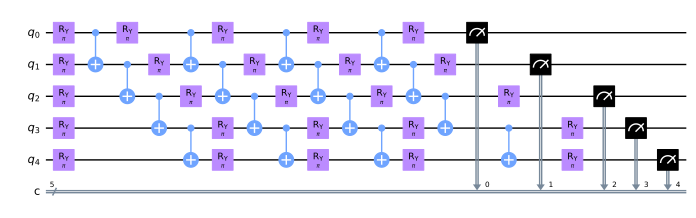

In [200]:
circuit_grid_model = CircuitGridModel()
circuit = circuit_grid_model.compute_circuit()

print("\nComplete Quantum Circuit:")
display(circuit.draw(output='mpl',scale=0.7))

## Main Loop and Print Results
First extract all nodes with gates suitable for rotation ans intialize first rotation of those with $\pi$. At the beginning, all Ry Gates will be indeed Pauli Y Gates.

After that we will run the first Optimization iteration befor going to the actual main loop.

In the main loop showing as a `while` we will **print** the Iteration number, the rotating gate, the position in the 5x21 matrix, the energy of this iteration, and the optimal basis state so far.

Then we will try to **optimize** calling `optimize_rotations` function. During the optimization we will also print the simulated Ansatz State that results after the optimization quantum circuit. The output will be a **sum of the basis states and its probability**.

Once the optimization comes to an end and we get out of the loop we will print the final Energy and Optimal Base State as a result

In [201]:
# INITIALIZATION OF FIRST CIRCUIT AND FIRST ENERGY
rotation_gate_nodes = circuit_grid_model.get_rotation_gate_nodes()
optimized_rotations = np.full(len(rotation_gate_nodes), np.pi)
num_times_rot_dir_change = np.zeros(len(optimized_rotations))

energy, prob_distro, maxindex = calc_new_energy(circuit_grid_model, rotation_gate_nodes)

# MAIN OPTIMIZATION LOOP    
while not Fin_optimizacion:
    if cur_rotation_num != len(optimized_rotations):
        print(' Iteration #' + str(iteration+1) , ', Rotating Gate #' , str(cur_rotation_num+1) , 
        '(Wire, Column) = (', rotation_gate_nodes[cur_rotation_num].wire_num+1, ',' , 
        rotation_gate_nodes[cur_rotation_num].column_num+1, '). Energy:', "{:.6f}".format(energy),
        ', Best Basis State:', basis_states[maxindex], "\n")
        #print(' Ansatz:',prob_distro,"\n")
    energy, prob_distro, maxindex = optimize_rotations(circuit_grid_model, rotation_gate_nodes)
    iteration +=  1

# PRINT FINAL RESULT        
print("\n-------------------------------------------------------- \n")
print('Final Energy: ', "{:.6f}".format(np.real(energy)), ', Optimal Basis State:', basis_states[maxindex])
print("\n-------------------------------------------------------- \n")
print('Ansatz:',prob_distro)
print("\n-------------------------------------------------------- \n")

Ansatz: {'00111': 1024}
 Iteration #1 , Rotating Gate # 1 (Wire, Column) = ( 1 , 1 ). Energy: -1.000000 , Best Basis State: 00111 

Ansatz: {'10110': 32, '00111': 992}
 Iteration #2 , Rotating Gate # 1 (Wire, Column) = ( 1 , 1 ). Energy: -1.031250 , Best Basis State: 00111 

Ansatz: {'10110': 140, '00111': 884}
 Iteration #3 , Rotating Gate # 1 (Wire, Column) = ( 1 , 1 ). Energy: -1.136719 , Best Basis State: 00111 

Ansatz: {'10110': 313, '00111': 711}
 Iteration #4 , Rotating Gate # 1 (Wire, Column) = ( 1 , 1 ). Energy: -1.305664 , Best Basis State: 00111 

Ansatz: {'10110': 517, '00111': 507}
 Iteration #5 , Rotating Gate # 1 (Wire, Column) = ( 1 , 1 ). Energy: -1.504883 , Best Basis State: 10110 

Ansatz: {'10110': 707, '00111': 317}
 Iteration #6 , Rotating Gate # 1 (Wire, Column) = ( 1 , 1 ). Energy: -1.690430 , Best Basis State: 10110 

Ansatz: {'10110': 847, '00111': 177}
 Iteration #7 , Rotating Gate # 1 (Wire, Column) = ( 1 , 1 ). Energy: -1.827148 , Best Basis State: 10110 


Ansatz: {'10101': 992, '01010': 32}
 Iteration #65 , Rotating Gate # 16 (Wire, Column) = ( 1 , 16 ). Energy: -6.000000 , Best Basis State: 10101 

Ansatz: {'10101': 893, '01010': 131}
 Iteration #66 , Rotating Gate # 16 (Wire, Column) = ( 1 , 16 ). Energy: -6.000000 , Best Basis State: 10101 

Ansatz: {'10101': 726, '01010': 298}
 Iteration #67 , Rotating Gate # 16 (Wire, Column) = ( 1 , 16 ). Energy: -6.000000 , Best Basis State: 10101 

Ansatz: {'10101': 507, '01010': 517}
 Iteration #68 , Rotating Gate # 16 (Wire, Column) = ( 1 , 16 ). Energy: -6.000000 , Best Basis State: 01010 

Ansatz: {'10101': 312, '01010': 712}
 Iteration #69 , Rotating Gate # 16 (Wire, Column) = ( 1 , 16 ). Energy: -6.000000 , Best Basis State: 01010 

Ansatz: {'10101': 153, '01010': 871}
 Iteration #70 , Rotating Gate # 16 (Wire, Column) = ( 1 , 16 ). Energy: -6.000000 , Best Basis State: 01010 

Ansatz: {'10101': 36, '01010': 988}
 Iteration #71 , Rotating Gate # 16 (Wire, Column) = ( 1 , 16 ). Energy: -6.0

Histogram: 


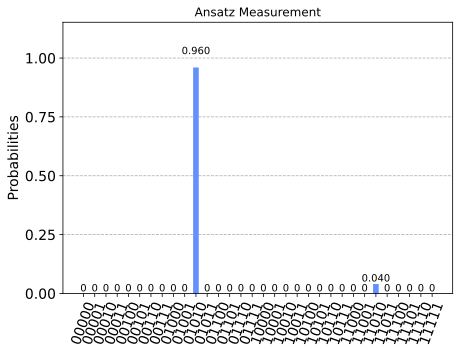

In [203]:
print('Histogram: ')
plot_histogram(prob_distro, title="Ansatz Measurement")